# Towards a Prototype to Leverage Archival Diplomatics to Develop a Framework to Detect and Prevent Fake Video
## Authors: Michel Barbeau, Nicholas Rivard
## Version: Jun 7, 2024

In [1]:
# DEPENDENCIES ----------------------------------------------------------------------------------------------------------------
import warnings
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import neo4j

/home/me/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [30]:
# LOAD DATA -------------------------------------------------------------------------------------------------------------------
G = nx.read_graphml('data.graphml')

/home/me/.local/lib/python3.10/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id init. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/me/.local/lib/python3.10/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id code. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/me/.local/lib/python3.10/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id evidence. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/me/.local/lib/python3.10/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id claim. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/me/.local/lib/python3.10/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/home/me/.local/li

# Compute Trustworthiness Scores

In [31]:
# PROPAGATION ALGORITHM -------------------------------------------------------------------------------------------------------
def MTF(G, lambda_tr=0.90, max_iterations=1, tolerance=0.01):
    # initial trustworthiness scores
    scores = {
        node: float(G.nodes[node]['init'])
        for node in G.nodes
    }   
    # compute Response scores
    for node in G.nodes:
            if G.nodes[node]['labels']==':Response':
                scores[node] = (1 - lambda_tr) * scores[node]
                # propagate from Participants
                for neighbor in G.nodes:
                    if node in G.neighbors(neighbor):
                        scores[node] += lambda_tr * scores[neighbor]
    # compute Claim scores
    for node in G.nodes:
        if G.nodes[node]['labels']==':Claim':
            # propagate from Responses
            for neighbor in G.nodes:
                if node in G.neighbors(neighbor) and G.nodes[neighbor]['labels']==':Response':
                    if G.nodes[neighbor]['claim'] == G.nodes[node]['claim']:
                        scores[node] += scores[neighbor]
    return scores


# NAMED SCORES ----------------------------------------------------------------------------------------------------------------
def named_scores(G, scores):
    i = 0
    nscores = {}
    for node in G.nodes:
        # Participants
        if G.nodes[node]['labels'] == ':Participant':
            k = G.nodes[node]['code']
            l = 'Participant'
        # Claims
        elif G.nodes[node]['labels'] == ':Claim':
            k = G.nodes[node]['claim']
            l = 'Claim'
        # Responses
        elif G.nodes[node]['labels'] == ':Response':
            k = G.nodes[node]['claim'] + str(i)
            i+= 1
            l = 'Response'
        # unrecognized label
        else:
            print('[ERR] ' + node + ' has unrecognized label: ' + G.nodes[node]['labels'])
        nscores[k] = {"label":l, "score":scores[node]}
    return nscores
    

# RUN -------------------------------------------------------------------------------------------------------------------------
scores = MTF(G, max_iterations=1)
#scores
nscores = named_scores(G,scores)
#display(nscores)

# Claim Scores

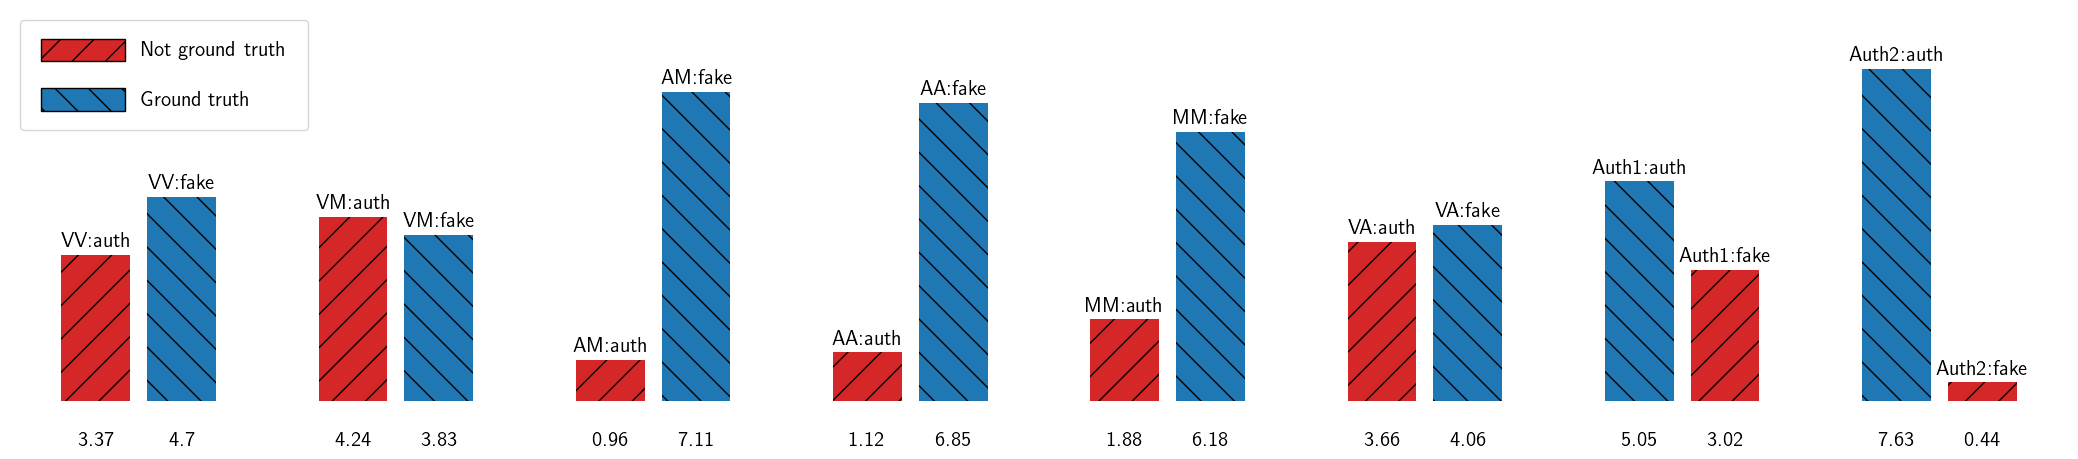

In [33]:
# GET CLAIM SCORES ------------------------------------------------------------------------------------------------------------
def get_claim_scores(nscores):
    i = 0
    k = list(nscores.keys())
    claim_scores = {}
    for score in nscores:
        if nscores[k[i]]['label'] == 'Claim':
            claim_scores[k[i]] = nscores[k[i]]['score']
        i += 1
    return claim_scores


# LABEL FORMATING -------------------------------------------------------------------------------------------------------------
def addlabels(x,y):
    x_pos = [1,2, 4,5, 7,8, 10,11, 13,14, 16,17, 19,20, 22,23]
    for i in range(16):
        plt.text(x[i], -1, round(y[i],2), ha = 'center')
        #plt.text(i, y[i]//2,y[i], ha = 'center', Bbox = dict(facecolor = 'white', alpha = .5))

# PLOT CLAIMS -----------------------------------------------------------------------------------------------------------------
def plot_claims(nscores):
    plt.style.use('_mpl-gallery')
    # get data
    x_pos = [1,2, 4,5, 7,8, 10,11, 13,14, 16,17, 19,20, 22,23]
    claim_scores = get_claim_scores(nscores)
    scores = []
    claims = []
    for claim in claim_scores:
        scores.append(claim_scores[claim])
        claims.append(claim)
    # bar formatting
    labels = ['VV:auth', 'VV:fake', 'VM:auth', 'VM:fake', 'AM:auth', 'AM:fake', 'AA:auth', 'AA:fake', 'MM:auth', 'MM:fake', 'VA:auth', 'VA:fake', 'Auth1:auth', 'Auth1:fake', 'Auth2:auth', 'Auth2:fake']
    colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red']
    patterns = ["/", "\\", "/", "\\", "/", "\\", "/", "\\", "/", "\\", "/", "\\", "\\", "/", "\\", "/"]
    # plot
    fig, ax = plt.subplots()
    fig.set_figwidth(21)
    fig.set_figheight(4)
    ax.bar(x_pos, scores, label=labels, color=colors, hatch=patterns)
    #ax.set_title('Claim scores')
    ax.set_xlabel("Claims")
    ax.set_ylabel("Scores")
    ax.set(xlim=(0, 8), xticks=np.arange(1, 25),
           ylim=(0, 8), yticks=np.arange(1, 10))
    plt.rcParams.update({'font.size': 15})
    plt.axis('off')
    rects = ax.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 0.1, label, ha="center", va="bottom"
        )
    #legend_labels = ['Not ground truth', 'Ground truth']
    #legend_colors = ['tab:blue', 'tab:red']
    legend_elements = [Patch(facecolor='tab:red', edgecolor='black', label='Not ground truth', hatch='/'),
                       Patch(facecolor='tab:blue', edgecolor='black', label='Ground truth', hatch='\\')]
    leg = ax.legend(handles=legend_elements, handlelength=4, labelspacing=1.5, borderpad=1, fontsize=15)
    for patch in leg.get_patches():
        patch.set_height(16)
        patch.set_y(-4)
    
    addlabels(x_pos, scores)
    plt.show()

# RUN -------------------------------------------------------------------------------------------------------------------------
#claim_scores = get_claim_scores(nscores)
#dict(sorted(claim_scores.items(), key=lambda item: item[1], reverse=True))
plot_claims(nscores)

# Participant Scores

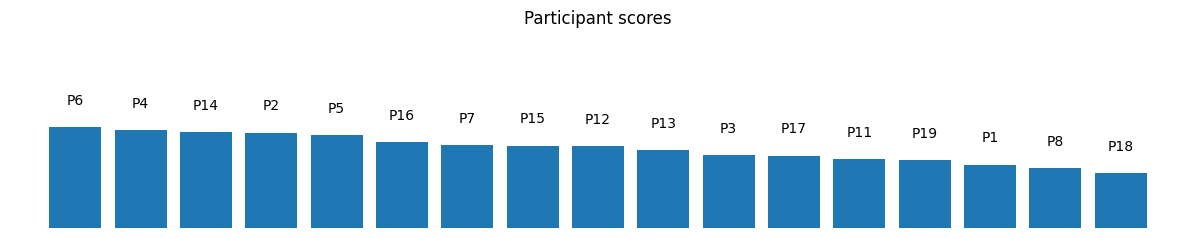

In [5]:
# GET PARTICIPANT SCORES ------------------------------------------------------------------------------------------------------
def get_participant_scores(nscores):
    i = 0
    k = list(nscores.keys())
    participant_scores = {}
    
    for score in nscores:
        if nscores[k[i]]['label'] == 'Participant':
            participant_scores[k[i]] = nscores[k[i]]['score']
        i += 1
    return participant_scores


# PLOT PASRTICIPANTS -----------------------------------------------------------------------------------------------------------------
def plot_participants(nscores):
    plt.style.use('_mpl-gallery')
    # get data
    x_pos = 1 + np.arange(17)
    participant_scores = get_participant_scores(nscores)
    ordered_scores = dict(sorted(participant_scores.items(), key=lambda item: item[1], reverse=True))
    scores = []
    labels = []
    for code in ordered_scores:
        scores.append(ordered_scores[code])
        labels.append(code)
    # plot
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(2)
    ax.bar(x_pos, scores, label=labels)
    ax.set_title('Participant scores')
    ax.set_xlabel("Participants")
    ax.set_ylabel("Scores")
    ax.set(xlim=(0, 8), xticks=np.arange(1, 19),
           ylim=(0, 1), yticks=np.arange(1, 1))
    plt.axis('off')
    rects = ax.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 0.1, label, ha="center", va="bottom"
        )
    plt.show()


# RUN -------------------------------------------------------------------------------------------------------------------------
#participant_scores = get_participant_scores(nscores)
#dict(sorted(participant_scores.items(), key=lambda item: item[1], reverse=True))
plot_participants(nscores)

# Response Scores

In [6]:
# GET RESPONSE SCORES ---------------------------------------------------------------------------------------------------------
def get_response_scores(nscores):
    i = 0
    k = list(nscores.keys())
    response_scores = {}
    for score in nscores:
        if nscores[k[i]]['label'] == 'Response':
            response_scores[k[i]] = nscores[k[i]]['score']
        i += 1
    return response_scores


# PLOT RESPONSES -----------------------------------------------------------------------------------------------------------------
def plot_responses(nscores):
    plt.style.use('_mpl-gallery')
    # get data
    x_pos = 1 + np.arange(17*8)
    response_scores = get_response_scores(nscores)
    ordered_scores = dict(sorted(response_scores.items(), key=lambda item: item[1], reverse=True))
    scores = []
    #labels = []
    for response in ordered_scores:
        scores.append(ordered_scores[response])
        #labels.append(response)
    # plot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(2)
    ax.bar(x_pos, scores)#, label=labels)
    ax.set_title('Response scores')
    ax.set_xlabel("Responses")
    ax.set_ylabel("Scores")
    ax.set(xlim=(0, 8), xticks=np.arange(1, 17*8+1.5),
           ylim=(0, 0.6), yticks=np.arange(1, 1))
    plt.axis('off')
    #rects = ax.patches
    #for rect, label in zip(rects, labels):
    #    height = rect.get_height()
    #    ax.text(
    #        rect.get_x() + rect.get_width() / 2, height + 0.1, label, ha="center", va="bottom"
    #    )
    plt.show()


# RUN -------------------------------------------------------------------------------------------------------------------------
response_scores = get_response_scores(nscores)
dict(sorted(response_scores.items(), key=lambda item: item[1], reverse=True))
#plot_responses(nscores)

{'VV is fake11': 0.5629625324786561,
 'VM is fake33': 0.5629625324786561,
 'AM is fake42': 0.5629625324786561,
 'AA is fake64': 0.5629625324786561,
 'MM is fake83': 0.5629625324786561,
 'VA is authentic91': 0.5629625324786561,
 'Apple is authentic107': 0.5629625324786561,
 'BBC is authentic124': 0.5629625324786561,
 'VV is fake8': 0.5479425341874695,
 'VM is authentic19': 0.5479425341874695,
 'AM is fake47': 0.5479425341874695,
 'AA is fake59': 0.5479425341874695,
 'MM is fake80': 0.5479425341874695,
 'VA is fake101': 0.5479425341874695,
 'Apple is authentic109': 0.5479425341874695,
 'BBC is authentic121': 0.5479425341874695,
 'VV is authentic0': 0.538526635010196,
 'VM is fake26': 0.538526635010196,
 'AM is fake37': 0.538526635010196,
 'AA is fake55': 0.538526635010196,
 'MM is fake75': 0.538526635010196,
 'VA is authentic87': 0.538526635010196,
 'Apple is authentic105': 0.538526635010196,
 'BBC is authentic132': 0.538526635010196,
 'VV is fake16': 0.5375766213998855,
 'VM is authenti

# VISUALIZATIONS

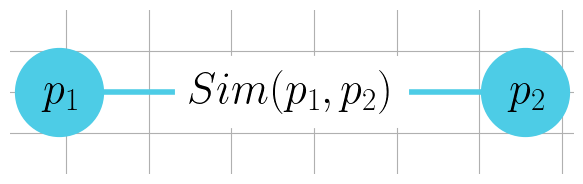

Figure 1.1


In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Graph to draw
G = nx.DiGraph(with_labels=False, rankdir="LR")
G.add_node(1,label=r"$p_1$")
G.add_node(2,label=r"$p_2$")
G.add_edges_from([(1,2)])

# Formatting
plt.rcParams['text.usetex'] = True

#plt.style.use('dark_background')
labels = {node:G.nodes[node]['label'] for node in G.nodes()}
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")

# Plot tree
fig, ax = plt.subplots(figsize=(6, 2), tight_layout=True)
nx.draw_networkx(G, pos=pos, ax=ax, with_labels=True, labels=labels, arrows=False, node_size=4000, node_color=[(0.3,0.8,0.9,1.0)], font_color="black", edge_color=[(0.3,0.8,0.9,1.0)], font_size=32, width=4, linewidths=1)
plt.box(False)
fig.tight_layout()

nx.draw_networkx_edge_labels(G, pos, {(1,2): r"$Sim(p_1,p_2)$"}, font_size=32, verticalalignment="center", clip_on=False)

plt.show()

print("Figure 1.1")